### Import necessary libraries

In [99]:
# Setup
import preprocess
import interpret
import annotate
import musics
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (25.0, 20.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Intialize global variables

In [151]:
# image file to process
input_file = 'sheet_music/Mary_Had_A_Little_Lamb.png'
# TODO accept pdfs? or at least throw error if not an image

# TODO bryant format this however you want -- just initialize file and notes data structures so we can pass them as params in the diff funcs
notes = dict()  # dictionary of {int noteID num : Note class instance}

key_signtaure = "C"  

### Preprocess image
Filter image, find staff lines and notes, gather useful data from image

x: 700, y: 510, note: F
x: 800, y: 520, note: E
x: 700, y: 531, note: D
x: 800, y: 541, note: C
x: 700, y: 552, note: B
x: 800, y: 562, note: A
x: 700, y: 573, note: G
x: 800, y: 583, note: F
x: 700, y: 594, note: E
x: 800, y: 604, note: D
x: 700, y: 615, note: C
x: 800, y: 625, note: N
x: 700, y: 636, note: N
x: 800, y: 646, note: N


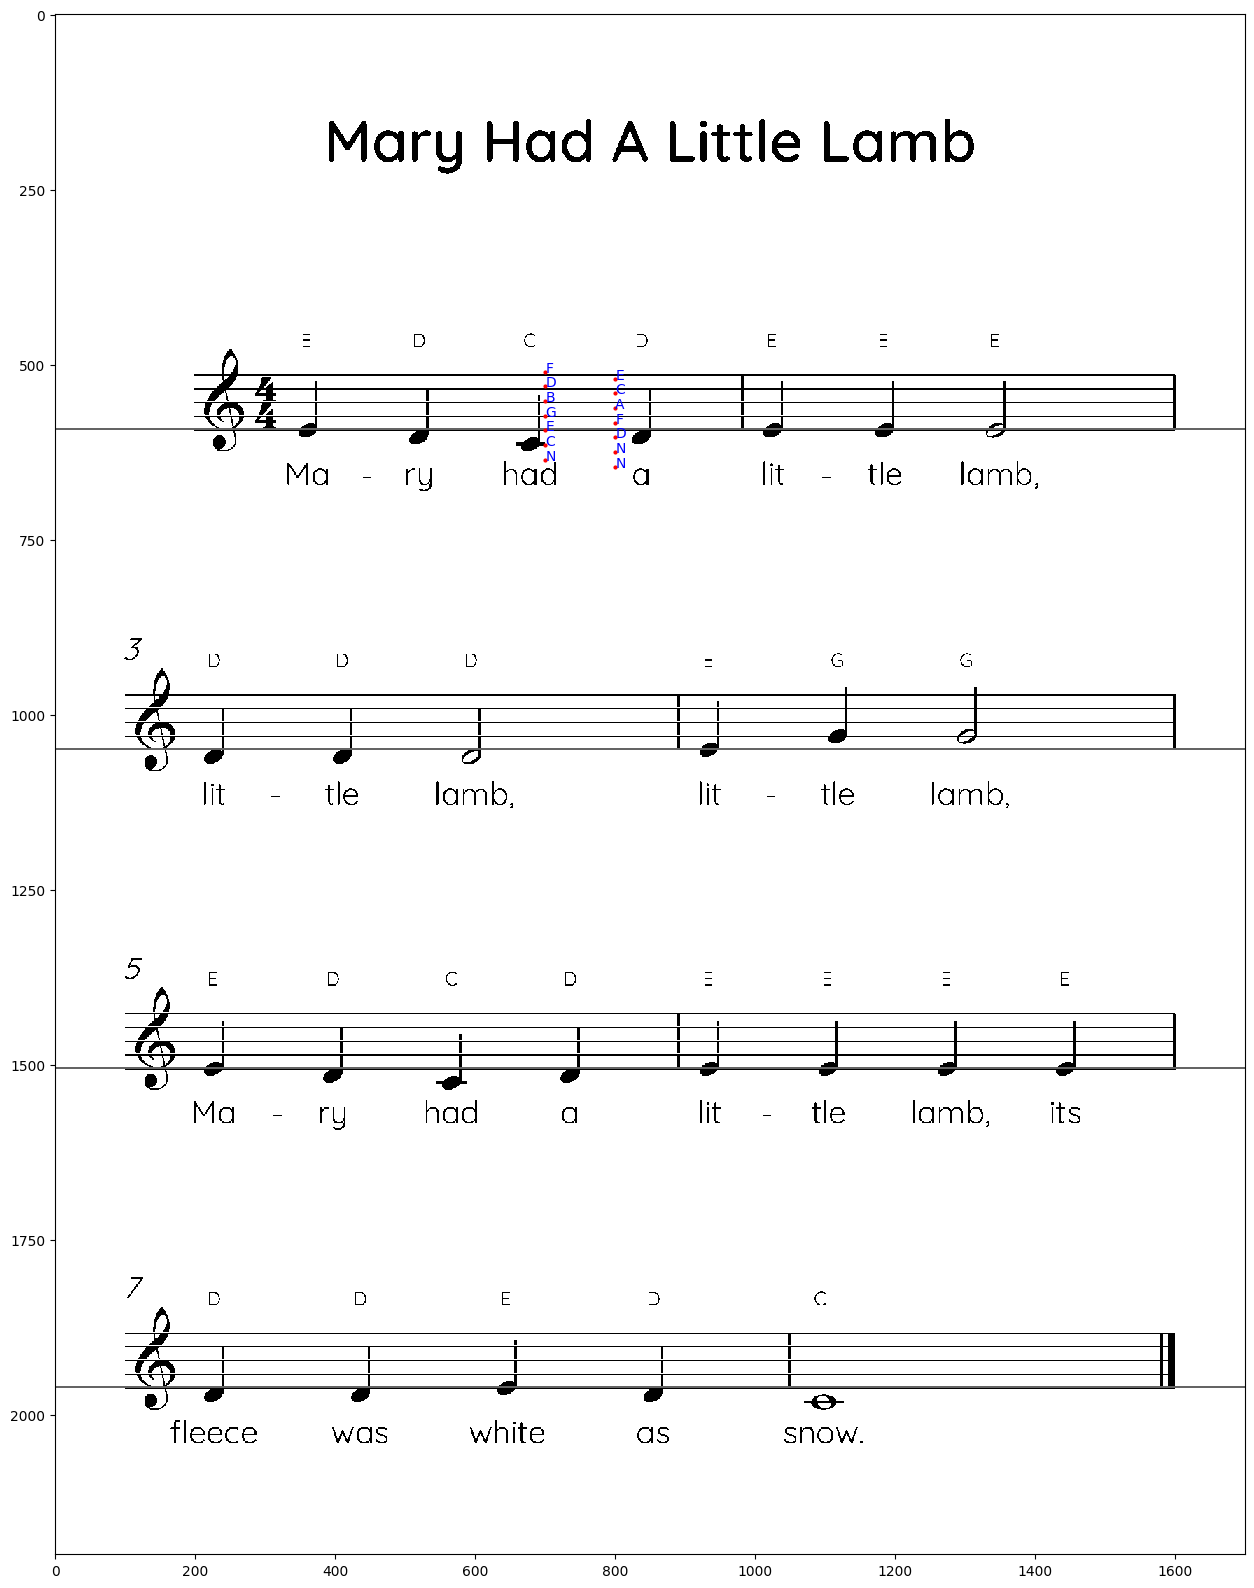

In [254]:
# reads input file as a numpy image
# returns grayscale version of image, and guassian blurred image
img, smoothed = preprocess.filter_img(input_file)

# TODO bryant identify staff lines
hor_lines = preprocess.horizontal_canny(img.copy())
base_lines, gap_size = preprocess.get_base_lines(img, hor_lines)
# TODO bryant take staff lines out of image

# Finds blobs of notes in image
blobs = preprocess.find_blobs(smoothed, display=False)
test_blobs = [(700, i) for i in range(510, 650, 21)]
test_blobs += [(800, i) for i in range(520, 650, 21)]
note_set = [musics.Note(b[0], b[1]) for b in test_blobs]
interpret.config_notes(base_lines, note_set, gap_size)
for note in note_set:
    print(f"x: {note.x}, y: {note.y}, note: {note.key}")
    plt.plot(note.x, note.y, 'ro', markersize=2)
    plt.text(note.x, note.y, note.key, color="blue")

test = img.copy()
for line in base_lines:
    cv2.line(test, (0, line), (2000, line), (100, 100, 0), 2)

plt.imshow(test)


# crop all blobs to images of individual notes
# return list of cropped images
cropped_notes = preprocess.get_cropped_notes(blobs, img, save=False)

### Interpret
Interpret gathered staff and note data, turning positional pixel data into musical notation

In [ ]:
# TODO call interpret funcs

### Annotate
Annotate the original image file with interpreted note letters, giving the user back an annotated file and MIDI audio file to practice with

In [ ]:
# TODO call annotate funcs